In [1]:
import numpy as np
from joblib import Parallel, delayed
import csv
from cqs.object import Instance
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.random import random_circuit
import qiskit.qasm3 as qasm3
from instances_b.reader_b import read_csv_b
from transpiler.transpile import transpile_circuit
from examples.benchmark.cqs_main import main_prober, main_solver
from qiskit.quantum_info import Operator
from tqdm import tqdm
from cqs.local.calculation import __estimate_V_dagger_V,__estimate_q,__reshape_to_Q_r
from cqs.optimization import solve_combination_parameters
from matplotlib import pyplot as plt
import time
import torch
from cqs.local.calculation import calculate_Q_r
import numpy as np
import pandas as pd
def normalize_quantum_state(vec):
    norm=np.sqrt(np.abs(vec.T.conjugate()@vec))
    return vec/norm

def __num_to_pauli_list(num_list):
    paulis = ['I', 'X', 'Y', 'Z']
    pauli_list = [paulis[int(i)] for i in num_list]
    return pauli_list

def __add_Pauli_gate(qc, which_qubit, which_gate):
    if which_gate == 0:
        qc.id(which_qubit)
    elif which_gate == 1:
        qc.x(which_qubit)
    elif which_gate == 2:
        qc.y(which_qubit)
    elif which_gate == 3:
        qc.z(which_qubit)
    else:
        return ValueError("Not supported Pauli gate type.")

def __num_to_pauli_circuit(num_list):
    n = len(num_list)
    num_list = [int(i) for i in num_list]
    qr = QuantumRegister(n, 'q')
    qc = QuantumCircuit(qr)
    for i in range(n):
        __add_Pauli_gate(qc, i, num_list[i])
    return qc

def create_random_circuit_in_native_gate(n, d):
    ub = random_circuit(num_qubits=n,max_operands=2, depth=d, measure=False)
    # ub = transpile_circuit(ub, device='Aria', optimization_level=2)
    return ub

In [4]:
losses=[]
with open('../3_qubit_data_generation_matrix_A.csv', 'r', newline='') as csvfile:
    data_b = read_csv_b(3)
    reader = csv.reader(csvfile, delimiter=' ', quotechar='|')
    for i, row in enumerate(reader):
        if i==501:
            row_clean = [j for j in ''.join(row).split('"') if j != ',']
            nLc = row_clean[0].split(',')
            n = int(nLc[0])
            print("qubit number is:", n)
            L = int(nLc[1])
            print("term number is:", L)
            kappa = float(nLc[2])
            print('condition number is', kappa)
            pauli_strings = [__num_to_pauli_list(l) for l in eval(row_clean[1])]
            print('Pauli strings are:', pauli_strings)
            pauli_circuits = [__num_to_pauli_circuit(l) for l in eval(row_clean[1])]
            coeffs = [float(i) for i in eval(row_clean[2])]
            print('coefficients are:', coeffs)
            print()

            # circuit depth d
            d = 3
            ub = qasm3.loads(data_b.iloc[5].qasm)
            print('Ub is given by:', data_b.iloc[5].b)
            print(ub)

            # generate instance
            instance = Instance(n, L, kappa)
            instance.generate(given_coeffs=coeffs, given_unitaries=pauli_circuits, given_ub=ub)
            Itr, LOSS, ansatz_tree = main_prober(instance, backend='qiskit-noiseless',ITR=None,
                                    shots=0, optimization_level=2,
                                    noise_level_two_qubit=0, noise_level_one_qubit=0, readout_error=0)
            print(Itr)
            print(LOSS)
            losses+=[LOSS]
            print('ANsatz tree contains:')
            # for qc in ansatz_tree:
            #     print(qc)
ansatz_tree=[ansatz_tree[i] for i in range(len(ansatz_tree)-1)]

Resolved file path: C:\Users\Nikita\PycharmProjects\CQS_singapore\instances_b\3_b_random_circuits.csv
Reading file: C:\Users\Nikita\PycharmProjects\CQS_singapore\instances_b\3_b_random_circuits.csv
qubit number is: 3
term number is: 3
condition number is 42.85682678222656
Pauli strings are: [['Z', 'Z', 'Y'], ['X', 'I', 'Y'], ['X', 'X', 'Y']]
coefficients are: [1.96, -0.68, -1.98]

Ub is given by: [(-0.11944869396006001+0j), (-0.16288579794352817-0.16288579794352817j), (0.34678707316580576+0j), (0.4728949916187479+0.4728949916187479j), (0.06405668487745207-0.06405668487745207j), (0.17470135309088772+0j), (-0.18597131143839568+0.18597131143839568j), (-0.5071982698844111+0j)]
     ┌────────────┐    ┌───┐     ┌─────┐
q_0: ┤ Ry(2.1849) ├────┤ S ├─────┤ Tdg ├
     ├────────────┤┌───┴───┴────┐└┬───┬┘
q_1: ┤ Ry(4.5511) ├┤ Ry(2.4782) ├─┤ Z ├─
     └─────┬──────┘├────────────┤ ├───┤ 
q_2: ──────■───────┤ Rx(4.9855) ├─┤ T ├─
                   └────────────┘ └───┘ 


Hadamard tests q Progress: 100%|██████████| 3/3 [00:00<00:00, 14.70it/s]


0.9101495742797852
loss: 0.898072151674952
combination parameters are: [(0.12459266930818558+5.748853972045564e-18j)]


Hadamard tests q Progress: 100%|██████████| 6/6 [00:00<00:00, 15.39it/s]


0.4127660393714905
loss: 0.39407949293478506
combination parameters are: [(-0.020296486094594002-0.02848016656935215j), (0.308048814535141+0.06055167689919472j)]


Hadamard tests q Progress: 100%|██████████| 9/9 [00:00<00:00, 15.31it/s]


0.3951573967933655
loss: 0.39407949293452493
combination parameters are: [(-0.19980309903621674+0.3634053170681j), (0.3080490529537201+0.06055164709687233j), (0.17950649559497833-0.3918853998184204j)]


Hadamard tests q Progress: 100%|██████████| 12/12 [00:00<00:00, 14.78it/s]


0.23272740840911865
loss: 0.22154658395363735
combination parameters are: [(-0.22539420425891876-0.562229573726654j), (0.5859279036521912+0.35931283235549927j), (0.2328120619058609+0.5635465979576111j), (0.3121170401573181+0.33557233214378357j)]


Hadamard tests q Progress: 100%|██████████| 15/15 [00:01<00:00, 14.06it/s]


0.1683332920074463
loss: 0.16492315352121356
combination parameters are: [(1.2547595500946045-0.5926841497421265j), (0.5076608657836914+0.49802422523498535j), (-1.2273344993591309+0.5585430264472961j), (0.23824168741703033+0.46650031208992004j), (-0.057576004415750504+0.10203983634710312j)]


Hadamard tests q Progress: 100%|██████████| 18/18 [00:01<00:00, 15.33it/s]


1.0728836059570312e-06
loss: 0.00024147122019524403
combination parameters are: [(0.5813892483711243-0.04404175654053688j), (0.8939929604530334-0.8468700051307678j), (-0.4296942949295044+0.013124597258865833j), (0.7552989721298218-0.9827667474746704j), (-0.10210564732551575+0.10488453507423401j), (-0.18992266058921814+0.5573947429656982j)]
[1, 2, 3, 4, 5, 6]
[0.898072151674952, 0.39407949293478506, 0.39407949293452493, 0.22154658395363735, 0.16492315352121356, 0.00024147122019524403]
ANsatz tree contains:


# NOISELESS

In [4]:
Q_true, r_true = calculate_Q_r(instance, ansatz_tree, backend='qiskit-noiseless', ITR=None,
                               shots=0, optimization_level=2,
                               noise_level_two_qubit=0, noise_level_one_qubit=0, readout_error=0)

Hadamard tests q Progress: 100%|██████████| 12/12 [00:01<00:00, 10.42it/s]


0.0
6.769962646036021e-08
[(1.3968349195637987e-17-0.09446858614683151j), (0.31842896342277527-3.953983877624311e-17j), (6.302547829137124e-17-0.1695561707019806j), (0.07648002356290817+2.067090932673269e-17j)]
[[1.0, 0.23874246416144873, 0.04036166897397997, 6.769986671262274e-08]]


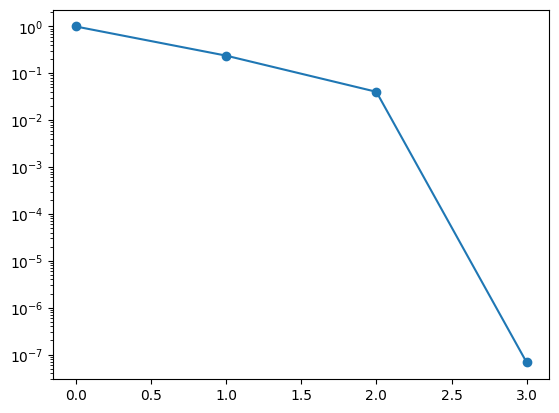

In [5]:
loss_test,alphas_true=solve_combination_parameters(Q_true,r_true,'ADAM')
print(loss_test)
print(alphas_true)
print(losses)
plt.plot(losses[0],"-o")
plt.yscale('log')
plt.show()

In [6]:
def find_true_loss_function(alphas,Q=Q_true,r=r_true):
    x=np.vstack((np.real(alphas),np.imag(alphas))).reshape(-1,1)
    depth=len(alphas)
    size_Q=len(Q)//2
    # Define the four sectors (quadrants)
    q1 = Q[:depth:, :depth:]
    q2 = Q[:depth:, size_Q:size_Q+depth:]
    q3 = Q[size_Q:size_Q+depth:, :depth:]
    q4 = Q[size_Q:size_Q+depth:, size_Q:size_Q+depth:]


    # Stack them back together
    top = np.hstack((q1, q2))
    bottom = np.hstack((q3, q4))
    Q1 = np.vstack((top, bottom))
    
    r1=r[:depth:]
    r2=r[size_Q:size_Q+depth:]
    
    r1=np.vstack((r1,r2)).reshape(-1,1)

    xt=torch.Tensor(x)
    Qt=torch.Tensor(Q1)*2
    rt=torch.Tensor(r1)*(-2)
    return (0.5*xt.T@torch.matmul(Qt, xt)+ rt.T@xt + 1).item()



# Noisy

Noise 0.014:  25%|██▌       | 1/4 [00:00<00:00,  3.83it/s]

1.0188900232315063


Noise 0.014:  50%|█████     | 2/4 [00:00<00:00,  3.93it/s]

0.36840617656707764


Noise 0.014:  75%|███████▌  | 3/4 [00:00<00:00,  3.86it/s]

0.03430318832397461


Noise 0.014: 100%|██████████| 4/4 [00:01<00:00,  3.12it/s]

2.384185791015625e-07


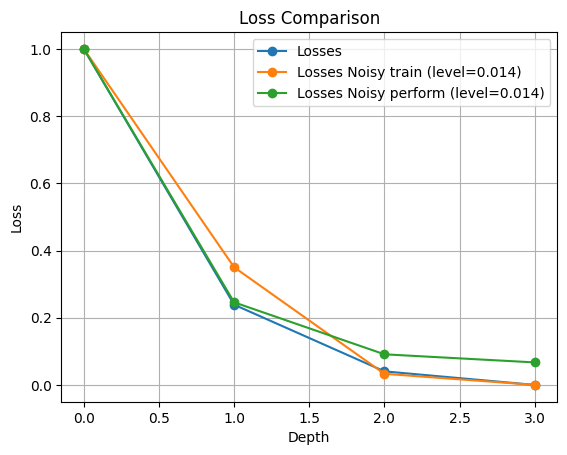

In [9]:
def process_noise_level(noises_level,device='qiskit_native'):
    V_dagger_V_noisy = __estimate_V_dagger_V(
        instance, ansatz_tree, loss_type=None, backend='qiskit-noisy', shots=1024, 
        optimization_level=2, noise_level_two_qubit=noises_level, 
        noise_level_one_qubit=0.001, readout_error=0.007,device=device
    )
    
    q_noisy = __estimate_q(
        instance, ansatz_tree, backend='qiskit-noisy', shots=1024, 
        optimization_level=2, noise_level_two_qubit=noises_level, 
        noise_level_one_qubit=0.001, readout_error=0.007,device=device
    )
    
    losses_noisy = []
    alphas_list = []
    losses_true = []
    
    for depth in tqdm(range(len(ansatz_tree)), desc=f"Noise {noises_level}"):
        Q, r = __reshape_to_Q_r(V_dagger_V_noisy[:depth+1, :depth+1], q_noisy[:depth+1])
        loss, alphas = solve_combination_parameters(Q, r, which_opt='ADAM')
        losses_noisy.append(loss)
        alphas_list.append(alphas)  # Store alphas for each depth
        losses_true+=[find_true_loss_function(alphas)]
    
    
    plt.plot(losses[0], "-o", label="Losses")
    plt.plot(losses_noisy, "-o", label=f"Losses Noisy train (level={noises_level})")
    plt.plot(losses_true, "-o", label=f"Losses Noisy perform (level={noises_level})")
    plt.legend()
    plt.xlabel("Depth")
    plt.ylabel("Loss")
    plt.title("Loss Comparison")
    plt.grid(True)
    plt.show()

for noises_level in [0.014]:
    process_noise_level(noises_level,device="Aria")
